##Alumno: Brian Alex Fuentes Acuña
##Padron: 101785

# Clase 13: Observador de estado de orden completo

Para realizar realimentación de las variables de estado debemos contar con ellas. Sin embargo, en todos los sistemas que vimos, las mediciones de variables disponibles o de interés suelen estar definidas por la señal de salida $y$.

Dado un sistema lineal e invariante en el tiempo:

$$ \dot{x} = A x + B u $$
$$ y = C x + D u$$

Vamos a querer realizar realimentación de estados $u = r + Kx$. Pero al contar con $y$, no vamos a tener exactamente el valor de $x$. Deberemos calcular una estimación del vector $x$, que llamaremos $\hat{x}$.

Los observadores del vector de estado son sistemas que nos permiten utilizar la información de la/s salida/s y de la/s entrada/s para obtener $\hat{x}$.

Repasá el video de la clase teórica (https://youtu.be/eF3Py44b8fc) y vayamos directo a resolver un ejemplo.

## Ejemplo: Controlador y observador en tiempo discreto de motor de CC

Resolvamos el ejercicio 1 de la guía 6 pero como si tuvieramos un controlador por computadora. Tenemos un sensor de posición angular del motor de CC, y = $\theta$ y buscamos implementar un control de posición similar al de la clase anterior.

Primero describamos el modelo en variables de estado en tiempo continuo a partir del modelo dado por transferencia:

$$ T(s) = \frac{\theta(s)}{V(s)} =  \frac{50}{s (s + 5)} $$

Corresponde a una ecuación diferencial:

$$ \ddot{\theta}(t) + 5 \dot{\theta}(t) = 50 v(t)$$

Y definimos las variables de estado de fase:

$$ x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} =\begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} $$

$$ \dot{x} = \begin{bmatrix} 0 & 1\\ 0 & -5 \end{bmatrix} x + \begin{bmatrix} 0 \\ 50\end{bmatrix} u $$

Y la salida:

$$ y = \theta = x_1 = \begin{bmatrix} 1 & 0 \end{bmatrix} x$$

In [ ]:
!pip install control
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

def zplane_plot(eigvals, title='Plano Z - Autovalores'):
    """Grafica autovalores en el plano complejo Z y el circulo unitario de referencia."""
    fig, axes = plt.figure(), plt.gca()
    unit_circle = plt.Circle([0, 0], radius=1, linestyle='--', fill=False)
    axes.add_artist(unit_circle)
    axes.plot(np.real(eigvals), np.imag(eigvals), 'x')
    plt.xlim((-1.5, 1.5))
    plt.ylim((-1.5, 1.5))
    plt.title(title)
    plt.ylabel(r'$\mathscr{Im}(\lambda)$')
    plt.xlabel(r'$\mathscr{Re}(\lambda)$')
    plt.grid()
    plt.show()

A = [[0, 1], [0, -5]]
B = [[0], [50]]
C = [[1, 0]]
D = [0]

motorcc = ctrl.ss(A,B,C,D)
print(motorcc)

Vamos a hallar un sistema equivalente discreto, pues vamos a trabajar con un controlador y observador que va a correr en una computadora.

Las especificaciones del sistema a lazo cerrado están dadas por:

* Autovalores del controlador dados por $\zeta = 0.707$ y $\omega_n = 10$ rad/s.
* Autovalores del observador dados por $\zeta_o = 0.5$ y $\omega_{no} = 20$ rad/s.

También vamos a tener que pasar estos autovalores a los equivalentes en tiempo discreto.

¿Cómo vamos a seleccionar el período de muestreo? Si queremos representar dinámicas tan rápidas como $T \simeq \omega_{no}/(2\pi)$ nos proponemos entonces elegirlo de la siguiente manera:


In [402]:
zeta = 0.707
wn = 10
zeta_obs = 0.5
wn_obs = 20
lambd = np.roots([1, 2*zeta*wn, wn**2])
lambd_obs = np.roots([1, 2*zeta_obs*wn_obs, wn_obs**2])

Ts = 2*np.pi/(max(wn, wn_obs))/10 # Por como es la respuesta oscilatoria subamortiguada, llega a representar al menos 10 puntos por período
Ts = np.round(Ts/10e-3)*10e-3 # Redondea a decenas de ms
print('Período de muestreo de', Ts, 's')

Período de muestreo de 0.03 s


Discretizamos de manera exacta con ese período de muestreo y convertimos también los autovalores a tiempo discreto.

In [403]:
print('Modelo del motor en tiempo discreto:')
motorcc_d = ctrl.c2d(motorcc, Ts)                                               #por deafult ZOH
print(motorcc_d)
##-> zi= e^{si.T}
lambd_d = np.exp(lambd*Ts)
print('Autovalores a lazo cerrado en tiempo discreto', lambd_d)
lambd_obs_d = np.exp(lambd_obs*Ts)
print('Autovalores del observador en tiempo discreto:', lambd_obs_d)

Modelo del motor en tiempo discreto:
A = [[1.         0.0278584 ]
     [0.         0.86070798]]

B = [[0.02141595]
     [1.39292024]]

C = [[1. 0.]]

D = [[0.]]

dt = 0.03

Autovalores a lazo cerrado en tiempo discreto [0.79074661+0.17033146j 0.79074661-0.17033146j]
Autovalores del observador en tiempo discreto: [0.64303784+0.36785047j 0.64303784-0.36785047j]


Analizamos controlabilidad y observabilidad del sistema en tiempo discreto:

In [404]:
P = ctrl.ctrb(motorcc_d.A, motorcc_d.B)
if (np.linalg.matrix_rank(P) == len(motorcc_d.A)):
  print('El sistema es controlable.')
else:
  print('El sistema no es controlable.')
  
Q = ctrl.obsv(motorcc_d.A, motorcc_d.C)
if (np.linalg.matrix_rank(Q) == len(motorcc_d.A)):
  print('El sistema es observable.')
else:
  print('El sistema no es observable.')


El sistema es controlable.
El sistema es observable.


El siguiente paso es calcular las ganancias K de la realimentación de variables de estado y las ganancias L del observador. Sabemos que gracias al principio de separación, podemos realizar indistintamente y en el orden que queramos el cálculo de K del realimentador de estados y de L del observador. El polinomio característico del sistema completo a lazo cerrado con observador, es el producto de los polinomios característicos deseados para la dinámica del sistema a lazo cerrado y para la dinámica del observador.

También vamos a utilizar la dualidad

In [405]:
K = -ctrl.place(motorcc_d.A, motorcc_d.B, lambd_d)
print('Las ganancias del controlador son:', K)
L_t = ctrl.place(motorcc_d.A.transpose(), motorcc_d.C.transpose(), lambd_obs_d)
L = L_t.transpose()
print('Las ganancias del observador son:', L)

Las ganancias del controlador son: [[-1.74213821 -0.17366766]]
Las ganancias del observador son: [[0.57463229]
 [6.55795836]]


Para poder simular el sistema completo, vamos a tener que definir un sistema agrandado que incluya variables de estado del sistema y variables de estado del observador:

$$x_t = \begin{bmatrix} x\\ \hat{x} \end{bmatrix} $$

Por suerte ya lo tenemos hecho en la teórica, para demostrar el principio de separación llegamos a:

$$ \dot{x}_t = \begin{bmatrix}A & BK \\ LC & A-LC+BK \end{bmatrix} x_t + \begin{bmatrix} B \\ B\end{bmatrix} r $$

Como primer paso, definamos el sistema completo y analicemos la ubicación de sus autovalores.

Los autovalores son: [0.64303784+0.36785047j 0.64303784-0.36785047j 0.79074661+0.17033146j
 0.79074661-0.17033146j]


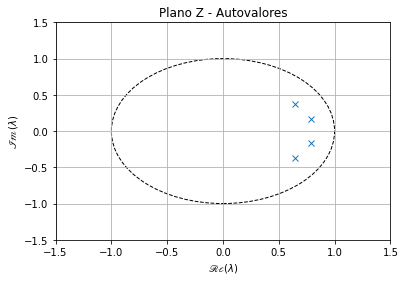

In [406]:
A_t = np.bmat([[motorcc_d.A, motorcc_d.B*K], [L*motorcc_d.C, motorcc_d.A-L*motorcc_d.C+motorcc_d.B*K]])
lambd_t = np.linalg.eigvals(A_t)
print('Los autovalores son:', np.linalg.eigvals(A_t))
zplane_plot(lambd_t)
B_t = np.bmat([[motorcc_d.B], [motorcc_d.B]])
C_t = np.bmat([[motorcc_d.C, np.zeros((1,len(A)))]])
D_t = np.zeros((1,1))

Simulemos ahora la respuesta del sistema ante unas condiciones iniciales no nulas. 

Primero, comparamos la dinámica del observador, $K=0$ y el sistema para $r=0$. Deberíamos esperar que el error tienda a 0.


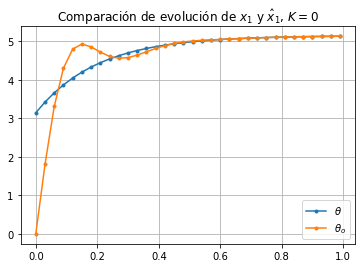

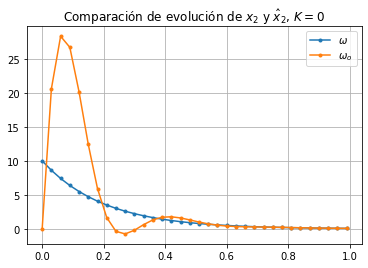

In [407]:
K = K*0 # Anulamos cada elemento
A_t = np.bmat([[motorcc_d.A, motorcc_d.B*K], [L*motorcc_d.C, motorcc_d.A-L*motorcc_d.C+motorcc_d.B*K]])
sys = ctrl.ss(A_t, B_t, C_t, D_t, Ts)

# Definición de condiciones iniciales
theta0 = np.pi
omega0 = 10
theta0_o = 0
omega0_o = 0
x0 = [[theta0], [omega0], [theta0_o], [omega0_o]]

# Tiempos de simulación
t_ini = 0
t_final = 1
t_step = Ts
t = np.arange(t_ini, t_final, t_step)

# Simulación y análisis de resultados
_, yout, xout = ctrl.initial_response(sys, t, X0=x0, return_x=True)
plt.plot(t, xout[0,:],'.-', label='$\\theta$')
plt.plot(t, xout[2,:],'.-', label='$\\theta_o$')
plt.legend()
plt.title('Comparación de evolución de $x_1$ y $\hat{x}_1$, $K=0$')
plt.grid()
plt.show()
plt.figure()
plt.plot(t, xout[1,:],'.-', label='$\\omega$')
plt.plot(t, xout[3,:],'.-', label='$\\omega_o$')
plt.legend()
plt.title('Comparación de evolución de $x_2$ y $\hat{x}_2$, $K=0$')
plt.grid()
plt.show()

Notar que estamos suponiendo que el motor tiene una posición inicial de $\pi$ y velocidad angular inicial de $10~$rad/s. Sin embargo, por posible desconocimiento en el observador fijamos condiciones iniciales nulas.
Se observa que el error $x-\hat{x}$ tiende a 0, o equivalentemente $x$ tiende a $\hat{x}$.

**Para pensar y probar** ¿Qué esperas ver si no hay error en la condición inicial, es decir, si $x_0 = \hat{x}_0$?.

**RTA:** el observador siempre tiende a estimar las variables de estado, la gracia de ello es que si se tienen condiciones iniciales distintas(lo usual en la practica) luego de un tiempo seran las mismas, siempre.
Si las condiciones iniciales son las mismas, estonces tanto observador como el sistema te daran la misma informacion , seran indenticas en todo instante.

Apliquemos ahora la ganancia K hallada y repitamos la simulación.

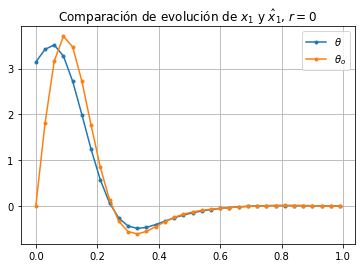

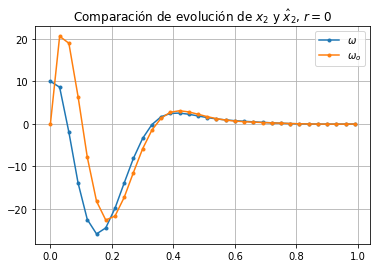

In [408]:
K = -ctrl.place(motorcc_d.A, motorcc_d.B, lambd_d)
A_t = np.bmat([[motorcc_d.A, motorcc_d.B*K], [L*motorcc_d.C, motorcc_d.A-L*motorcc_d.C+motorcc_d.B*K]])
sys = ctrl.ss(A_t, B_t, C_t, D_t, Ts)

# Definición de condiciones iniciales
theta0 = np.pi
omega0 = 10
theta0_o = 0
omega0_o = 0

# Tiempos de simulación
t_ini = 0
t_final = 1
t_step = Ts
t = np.arange(t_ini, t_final, t_step)
x0 = [[theta0], [omega0], [theta0_o], [omega0_o]]

# Simulación y análisis de resultados
_, yout, xout = ctrl.initial_response(sys, t, X0=x0, return_x=True)
plt.plot(t, xout[0,:],'.-', label='$\\theta$')
plt.plot(t, xout[2,:],'.-', label='$\\theta_o$')
plt.legend()
plt.title('Comparación de evolución de $x_1$ y $\hat{x}_1$, $r=0$')
plt.grid()
plt.show()
plt.figure()
plt.plot(t, xout[1,:],'.-', label='$\\omega$')
plt.plot(t, xout[3,:],'.-', label='$\\omega_o$')
plt.legend()
plt.title('Comparación de evolución de $x_2$ y $\hat{x}_2$, $r=0$')
plt.grid()
plt.show()

En los resultados de arriba se nota como la realimentación de estados hace que siga la referencia $r=0$ sin error. Además, como el sistema es exponencialmente estable a lazo cerrado, debido a los autovalores del diseño, la velocidad también tiende a 0.

¿Qué sucede si ahora queremos que siga una referencia no nula?

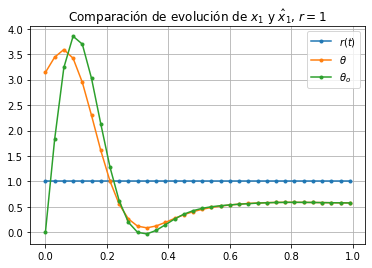

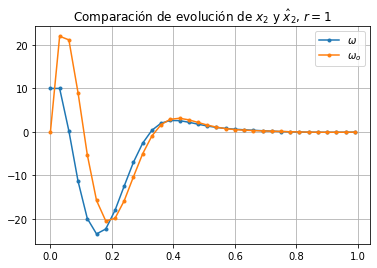

In [409]:
_, yout, xout = ctrl.step_response(sys, t, X0=x0, return_x=True)
plt.plot(t, np.ones((len(t),1)), '.-', label='$r(t)$')
plt.plot(t, xout[0,:],'.-', label='$\\theta$')
plt.plot(t, xout[2,:],'.-', label='$\\theta_o$')
plt.legend()
plt.title('Comparación de evolución de $x_1$ y $\hat{x}_1$, $r=1$')
plt.grid()
plt.show()
plt.figure()
plt.plot(t, xout[1,:],'.-', label='$\\omega$')
plt.plot(t, xout[3,:],'.-', label='$\\omega_o$')
plt.legend()
plt.title('Comparación de evolución de $x_2$ y $\hat{x}_2$, $r=1$')
plt.grid()
plt.show()

Vemos que no sigue sin error la referencia, pues con el pulso unitario en la entrada $r(t)$, $\theta$ llega a un valor un poco por encima de 0.5.

## Tarea

1. Utilice algún método para que el sistema antes diseñado no presente error en estado estacionario. Repita la prueba con un escalón distinto para mostrar el resultado, por ejemplo, $r=\pi$. Justifique los cálculos utilizados.
---
**RTA:**

A partir del sistema ya diseñado se opta por aplicar acción integral y así poder
obtener un sistema robusto.

Para la acción integral solo se necesita tomar la salida $y(t)$ del sistema y compararla con


$$ \dot{x}_a(t) = r^*(t) - y(t)= r^* - Cx(t) - CDu(t)$$
$$ r(t)= K_a x_a(t) $$

se define entonces las nuevas variables de estado:

$$x^* = \begin{bmatrix} x\\ \hat{x}\\ x_a \end{bmatrix} $$

como $D= 0$

$$ \dot{x}^* = \begin{bmatrix}A & BK &BK_a\\ LC & A-LC+BK & BK_a\\-C & 0& 0 \end{bmatrix} x^* + \begin{bmatrix} 0 \\ 0\\ 1\end{bmatrix} r^* $$

finalmente se usa el nuevo sistema *continuo*

Como antes se tenia un sistema discretizado se vuelve a calcular las matrices ya con el sistema ampliado como tal y luego se lo discretiza.

In [410]:

#Defino el sistema ampliado con accion integral para un sistema CONTINUO
t_ini = 0
t_final = 10
t_step = Ts
t = np.arange(t_ini, t_final, t_step)

#Vuelvo a buscar las ganancias
K = -ctrl.place(motorcc.A, motorcc.B, lambd)
print('Las ganancias del controlador son:', K)
L_t = ctrl.place(motorcc.A.transpose(), motorcc.C.transpose(), lambd_obs)
L = L_t.transpose()
print('Las ganancias del observador son:', L)


Las ganancias del controlador son: [[-2.     -0.1828]]
Las ganancias del observador son: [[ 15.]
 [325.]]


In [411]:
"""
matlab:
Aa= [ A+B*K   -B*K   B*Ka; L*C   A-L*C+B*K B*Ka; -C   zeros(1,  length(B*K)+ 1 )]
Ba = [ [zeros(2*length(A), 1 )]; [ones(1, 1)] ]   
Ca = [C zeros(1, 3)]
Da = zeros(1,1)
"""
Ka= 2  #el Ka afecta a la dinamica del sistema.

Aa= np.bmat([[motorcc.A + motorcc.B*K, -motorcc.B*K, motorcc.B*Ka], 
             [L*motorcc.C, motorcc.A-L*motorcc.C+motorcc.B*K, motorcc.B*Ka], 
             [-motorcc.C, np.zeros((1, len(motorcc.B*K)+1))]])

Ba = np.bmat( [ [np.zeros( (2*len(motorcc.A), 1) )], [np.ones((1, 1))] ] )  
Ca = np.bmat([[motorcc.C, np.zeros((1,3))]])
Da = np.zeros((1,1))

sys_rbt = ctrl.ss(Aa, Ba, Ca, Da)

#Discretizo
sys_rbt_d = ctrl.c2d(sys_rbt, Ts)

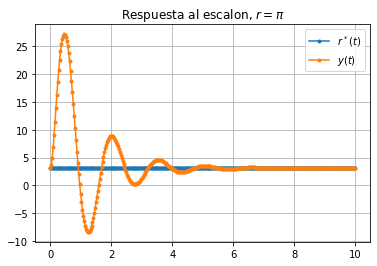

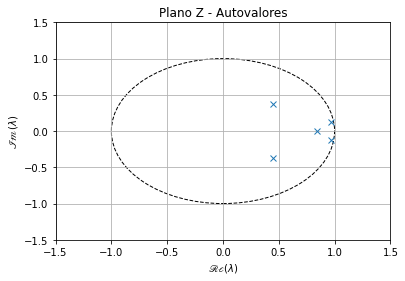

In [412]:
x0 = [[theta0], [omega0], [theta0_o], [omega0_o], [10]]
escalon= np.pi*np.ones((len(t),1))

_, yout, xout = ctrl.forced_response(sys_rbt_d, t, escalon.transpose(), X0=x0, return_x=True)

plt.plot(t, escalon, '.-', label='$r^*(t)$')
plt.plot(t, yout,'.-', label='$y(t)$')
plt.legend()
plt.title('Respuesta al escalon, $r= \pi $')
plt.grid(True)
plt.show()

lambd_t = np.linalg.eigvals(sys_rbt_d.A)
#print('Los autovalores son:', np.linalg.eigvals(A_t))
zplane_plot(lambd_t)


2. Para el sistema de control sin error de seguimiento obtenido en el punto anterior:

* a) Ensaye el escalón unitario y analice los valores que toma $u(t)$, la acción de control. 


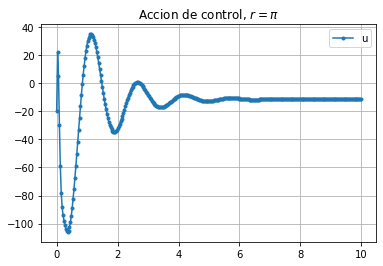

In [413]:
#U=K*X_casa + Ka*Xa
#[X1 x2, X_casa1 X_casa2, Xa]

X_casa= xout[[1, 2],:]
Xa= xout[3,:]

U_accion_control= K[0,0]*X_casa[0] + K[0,1]*X_casa[1] + Ka*Xa

plt.plot( t, U_accion_control, '.-')
plt.legend('u(t)')
plt.title('Accion de control, $r= \pi $')
plt.grid()
plt.show()


Se ve que la accion de control es a simple vista muy abrupta y requiere mucha energia en lo primeros segundos, hasta que la diferencia entre la entrada y salida sea nula.
Porsupuesto que ser muy "abrupta" es realtivo a casa sistema en si, depende de quien realice la accion de control y si puede hacerlo sin problemas en el tiempo.

* b) Rediseñe la realimentación de estados para obtener autovalores el doble de rápidos, pero manteniendo el coeficiente de amortiguamiento $\zeta$. Analice el efecto de estos nuevos requerimientos sobre $u(t)$ y compare. ¿Qué observa?. Seleccione convenientemente los nuevos autovalores del observador y justifique su elección.

**RTA:**
Como es un sistema de segundo orden, los autovalores tendrán la siguiente forma:

$$ S_{1,2}= -ζ w_n \pm j w_n \sqrt{1 - ζ^2} $$
polos dos veces mas rapidos entonces se traduce en:

$$ S^*_{1,2}= 2.S_{1,2}= -ζ 2.w_n \pm j 2.w_n \sqrt{1 - ζ^2} $$

finalmente se obtiene con $w^*_n= 2.w_n$ sin cambiar $ζ$.
$$ S^*_{1,2}= -ζ w^*_n \pm j w^*_n \sqrt{1 - ζ^2} $$

Esta forma vale en general para el controlador y el observador.

Según la teoría los autovalores del observador deben ser 2 a 5 veces más rápidos que los del controlador, esto para que no afecte a la dinámica de la planta, es decir si los autovalores del observador son más lentos que la de la planta, este formara parte de la salida haciendo más lento.
y por el otro lado si son muy grandes los autovalores teóricamente se puede pero a medida que se eligen polos más grandes en un caso extremo, el observador pasa de ser un filtro a ser un derivador(en parte) por lo que si la señal de salida, la cual es muestreada por algún sensor, tiene ruido entonces ponerle un derivador no es buena idea.


In [414]:
#zeta = 0.707
wn_ = wn*2                                  #
#zeta_obs = 0.5
wn_obs_ = wn_obs*4                          #  
lambd = np.roots([1, 2*zeta*wn_, wn_**2])
lambd_obs = np.roots([1, 2*zeta_obs*wn_obs_, wn_obs_**2])

Ts = 2*np.pi/(max(wn_, wn_obs_))/10 # Por como es la respuesta oscilatoria subamortiguada, llega a representar al menos 10 puntos por período
Ts = np.round(Ts/10e-3)*10e-3 # Redondea a decenas de ms
print('Período de muestreo de', Ts, 's')



Período de muestreo de 0.01 s


In [415]:
#Defino el sistema ampliado con accion integral para un sistema CONTINUO
t_ini = 0
t_final = 10
t_step = Ts
t = np.arange(t_ini, t_final, t_step)

#Vuelvo a buscar las ganancias
K = -ctrl.place(motorcc.A, motorcc.B, lambd)
print('Las ganancias del controlador son:', K)
L_t = ctrl.place(motorcc.A.transpose(), motorcc.C.transpose(), lambd_obs)
L = L_t.transpose()
print('Las ganancias del observador son:', L)


Las ganancias del controlador son: [[-8.     -0.4656]]
Las ganancias del observador son: [[  75.]
 [6025.]]


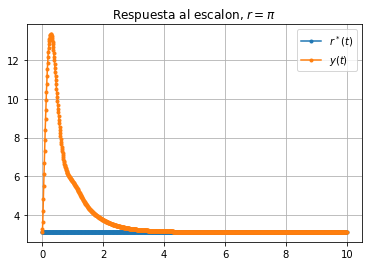

In [416]:
#Ka= 2                  #modifica la dinamica del sistema
Aa= np.bmat([[motorcc.A + motorcc.B*K, -motorcc.B*K, motorcc.B*Ka], 
             [L*motorcc.C, motorcc.A-L*motorcc.C+motorcc.B*K, motorcc.B*Ka], 
             [-motorcc.C, np.zeros((1, len(motorcc.B*K)+1))]])

Ba = np.bmat( [ [np.zeros( (2*len(motorcc.A), 1) )], [np.ones((1, 1))] ] )  
Ca = np.bmat([[motorcc.C, np.zeros((1,3))]])
Da = np.zeros((1,1))

sys_rbt = ctrl.ss(Aa, Ba, Ca, Da)
sys_rbt_d = ctrl.c2d(sys_rbt, Ts)

escalon= np.pi*np.ones((len(t),1))

_, yout, xout = ctrl.forced_response(sys_rbt_d, t, escalon.transpose(), X0=x0, return_x=True)


plt.plot(t, escalon, '.-', label='$r^*(t)$')
plt.plot(t, yout,'.-', label='$y(t)$')
plt.legend()
plt.title('Respuesta al escalon, $r= \pi $')
plt.grid(True)
plt.show()


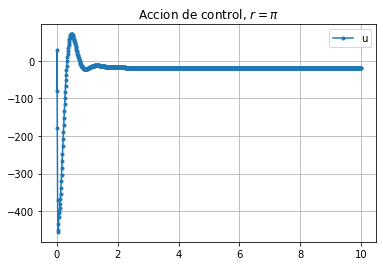

In [417]:
X_casa= xout[[1, 2],:]
Xa= xout[3,:]

U_accion_control= K[0,0]*X_casa[0] + K[0,1]*X_casa[1] + Ka*Xa

plt.plot( t, U_accion_control, '.-')
plt.legend("u(t)")
plt.title('Accion de control, $r= \pi $')
plt.grid()
plt.show()


Observar que el tiempo de establecimiento en este caso es menor, esto porque se ha puesto polos más rápidos y en definitiva se incrementó la frecuencia natural $w_n$ la cual es inversamente proporcional a dicho tiempo.

Notar que paso de estabilizarse aproximadamente en 6seg. a 4 seg.

A su vez el costo que se paga es que se necesita mayor acción de control que en el caso original. 

Notar que paso de una amplitud pico en módulo de 100 a 400, es decir, se requiere mayor energía en el segundo caso lo cual nuevamente dependiendo de quien realice la acción de control esto puede estar bien o ser muy difícil de realizar.
